# Label and Feature Creation
In this notebook, I will import the single-column DataFrame of appellate opinions and create columns with labels and features. 
## Contents:
<ul>
<li>0. Import Libraries 
<li>1. Clean up opinions 
<ul><li>A. Remove page numbers from opinions
    <li>B. Remove Supreme Court case
    <li>C. Drop Dissents 
    </ul>
<li>2. Add file numbers 
<li>3. Create Labels section 
<ul><li>A. Create function and apply to DataFrame 
<li>B. Clean up, combine, and drop columns
    <li>C. Address reversing-denials or affirming-denials </ul>
<li>4. Create case-type column 
<li>5. Extract Trial Court Judge 
<li>6. Extract County 
<li>7. Export DataFrame with Features
<li>8. EDA Visualizations - TBD
</ul>

Dataset Reduction:<br>
1052 rows dropped for not fitting the affirmed/reversed criteria (errors, affirmed in part, appeals dismissed, etc.)<br>
38 rows dropped for not conforming to a reasonable case type or being too short to have a reasonable effect.<br>
84 rows dropped from the Supreme Court, reviewing underlying decisions (lacking the features of court of appeals cases)<br>
49 rows dropped from the trial_judge extraction function which were either administrative or multiple orders.<br>
08 rows dropped from the county extraction section <br>


## 0. Import Libraries and DataFrame

In [1]:
import io
import re
import pandas as pd
import pickle
import operator

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# from nltk.corpus import stopwords
# from nltk import word_tokenize
# from nltk.stem.wordnet import WordNetLemmatizer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)


In [2]:
# Open the dataframe
infile = open('ProjectData/df_clean.data', 'rb')
df = pickle.load(infile)
infile.close()

In [3]:
df.reset_index(inplace=True, drop=True)

In [4]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 1 columns):
Opinion    3922 non-null object
dtypes: object(1)
memory usage: 30.8+ KB


(None,                                              Opinion
 0   an unpublished opinion of the north carolina ...
 1  no. coa11-246 north carolina court of appeals ...
 2  no. coa08-347 north carolina court of appeals ...
 3  michael harrison gregory and wife, vivian greg...
 4  atlantic contracting and material company, inc...)

## 1. Remove Page Numbers & Supreme Court Cases

### A. Remove Page Numbers
Page numbers (-1-) appear throughout the corpus and complicated some of the following functions.  Accordingly, they're removed here. 

In [5]:
def remove_page_nums(string_):
    """
    A function to remove page numbers from a given string
    Page numbers must be the format "-##-"
    """
    new_string = re.sub(" -\d+- ", " ", string_)
    return(new_string)

In [6]:
no_page_list = []
for i in range(len(df.Opinion)):
    x = remove_page_nums(df.Opinion[i])
    no_page_list.append(x)
    
df["Opinion"] = pd.Series(no_page_list).values

In [7]:
df.head()

,Opinion
0,an unpublished opinion of the north carolina ...
1,no. coa11-246 north carolina court of appeals ...
2,no. coa08-347 north carolina court of appeals ...
3,"michael harrison gregory and wife, vivian greg..."
4,"atlantic contracting and material company, inc..."


### Fix Irish Names (O'xxx)

In [8]:
def lose_the_apostrophe(string_):
    """
    A function to remove apostrophes from Irish names; 
    The majority of the tokenization will be performed
    on the following dataframe.
    """
    new_string = re.sub(" o’|o'", " o", string_)
    
    return(new_string)

In [9]:
no_apostrophes = []
for i in range(len(df.Opinion)):
    x = lose_the_apostrophe(df.Opinion[i])
    no_apostrophes.append(x)
    
df["Opinion"] = pd.Series(no_apostrophes).values

### B. Remove Supreme Court Cases (that review Court of Appeals cases)
These cases review the Court of Appeals' decisions; they don't typically include features the same way that the Court of Appeals does, and their rulings are usually affecting the Court of Appeals (which may be the opposite of the underlying case). Accordingly, they should be dropped for this project. 

In [10]:
df['SCT'] = 0

In [11]:
# capture file number into new column
def drop_SCT(string_):
    sct_yes = re.search("in the supreme court of north carolina",string_[:50])
    if sct_yes == None:
        return(0)
    else:
        return(1)

In [12]:
df['SCT'] = df.Opinion.map(lambda x: drop_SCT(x))
len(df.loc[df['SCT'] == 1])

84

In [13]:
# drop supreme court cases
df.drop(list(df.loc[df['SCT'] == 1].index), inplace=True)
df.reset_index(inplace=True, drop=True)

### C. Trim Dissents, Because They are Not Relevant to the Function

#Dissents follow the opinion, when one of the three appellate judges doesn't agree; they may trigger further appeal, but they are not law, and may skew results, so they should be dropped. 

#### Exploration of opinions containing the phrase "dissenting"

In [14]:
dissents = df.loc[df['Opinion'].str.contains("dissenting")]

In [15]:
dissents.head()

,Opinion,SCT
13,"energy investors fund, l.p., inc., kvaerner as...",0
22,in the court of appeals of north carolina no....,0
27,"cecelia l. ford, administrator of the estate o...",0
35,"carolina place joint venture, plaintiff-appell...",0
45,christian emerson dysart and mildred maxwell d...,0


Review example opinions containing the word "dissent" to see which need to be dropped:</p>
Verbiage: (Y=actual dissent N=not a dissent)<br>
Y judge horton dissenting<br>
Y judge wynn dissents. ... wynn, judge, dissenting.<br>
Y tyson, judge dissenting.<br>
Y judge tyson concurs in part, dissents in part.<br>
Y calabria, judge, dissenting. // therefore, i respectfully dissent.<br>
Y justice martin dissenting. -- Conflicts w below -- maybe eliminate first 2000 chars? <br>
Y === wynn, judge dissenting.<br>
Y - elmore, judge, dissenting.<br>
Y. martin, chief judge, concurring in part, dissenting in part. - But later<br>
Y = campbell, judge, dissenting. i respectfully dissent <br>
Y == thomas, judge, dissenting.<br>
Y judge dillon dissents in a separate opinion. - 12,600 chars into 17,000 char opi<br>
<br>
N piazza v. kirkbride tyson, j., concurring in part, dissenting in part.<br>
N souter, j., dissenting (cit<br>
N r. justice martin dissenting. justice brady dissenting. a -- too early  (913 chars in, 80,000 char opinion)<br>
N (greene, j. dissenting) - case citation<br>
N . judge elmore dissenting. -- too early, 2400 chars in to 28,000 char opinion<br>
N m. chief judge martin concurring in part and dissenting in part. - 2731 chars into 29,000 char opinion<br>
N (hudson, j., dissenting) <br>
N   1715 chars into 23,000 char opinion<br>
------ never the (j., dissenting)<br>
<br>
Pseudocode:<br>
IF ends with "judges /2 and /2 concur." (not concurs) - there isn't a dissent (one of the two would be dissenting). <br>
ELSE if after the first 3,000 chars, of the opinion:<br>
    judge /4 (dissent*)<br>
    
#### Trimming-Dissents Function Creation and Revision
Created the below function following the preceding review; ran the function and reviewed the trimmed opinions for correctness (i.e., was something more or less than a dissent trimmed from the opinion).  The function was updated to put (judge|justice) in parens and to make the verb "dissents" instead of the noun "dissent", which was pulling references to other dissents. 


In [16]:
def trim_dissents(opinion):
    global trimmed_dissents
    if re.search("(dissent)", opinion):
        if re.search("judges\W+(?:\w+\W+){0,5}?concur\b", opinion):
            return()  
        else:
            try:
                y = re.search("(?:(judge|justice)\W+(?:\w+\W+){0,6}?dissents)", opinion[3000:])
                cut_off_point = y.start()
                opinion2 = opinion[:(cut_off_point+3000)]
                trimmed_dissents += 1
                return(opinion2)
            except:
                return(opinion)
    else:
        return(opinion)

In [17]:
# Drop dissents
trimmed_dissents = 0
new_opinions = []
for i in range(len(df.Opinion)):
    x = trim_dissents(df.Opinion[i])
    new_opinions.append(x)
    
# Replate opinions with trimmed opinions
df["Opinion"] = pd.Series(new_opinions).values

## 2. Creating New Columns for the File Numbers and Years
The file numbers should have no predictive value; this section is more for EDA/visualizations than practical.

In [18]:
# capture file number into new column
def yr_filed(string_):
    try:
        year_filed = re.search("filed:? ?\d+ ?\D+ (\d+)",string_)
        return year_filed.group(1)
    except:
        return(0)

In [19]:
years = []
for i in range(len(df)):
    x = yr_filed(df.Opinion[i])
    years.append(x)

df["Year_Filed"] = pd.Series(years).values.astype(int)

In [20]:
df.describe()

,SCT,Year_Filed
count,3838.0,3838.000000
mean,0.0,2006.852006
std,0.0,55.212325
min,0.0,0.000000
25%,0.0,2004.000000
50%,0.0,2008.000000
75%,0.0,2013.000000
max,0.0,2020.000000


In [21]:
df.loc[df.Year_Filed < 1990]

,Opinion,SCT,Year_Filed
55,"parkwood association, plaintiff v. capital hea...",0,1532
56,"franklin r. dewitt v. eveready battery co., in...",0,0
585,"luther lee key, plaintiff v. barbara m. burche...",0,199
3380,correction: 6/10/99 - please add to attorney l...,0,0


In [22]:
# Handling errors in the data manually
df.Year_Filed.replace([0,199,1532], 1999, inplace=True)

In [23]:
df.describe()

,SCT,Year_Filed
count,3838.0,3838.000000
mean,0.0,2008.484367
std,0.0,5.997362
min,0.0,1998.000000
25%,0.0,2004.000000
50%,0.0,2008.000000
75%,0.0,2013.000000
max,0.0,2020.000000


In [24]:
# capture file number into new column
def coa(string_):
    try:
        pat_coa_number = re.search("no.? ?coa.? ?(\d{2}-\d{1,5})",string_)
        return pat_coa_number.group(1)
    except:
        return('00-000')

In [25]:
coa_numbers = []
for i in range(len(df)):
    x = coa(df.Opinion[i])
    coa_numbers.append(x)

df["File_Numbers"] = pd.Series(coa_numbers).values

In [26]:
df.head(5)

,Opinion,SCT,Year_Filed,File_Numbers
0,an unpublished opinion of the north carolina ...,0,2020,19-563
1,no. coa11-246 north carolina court of appeals ...,0,2012,11-246
2,no. coa08-347 north carolina court of appeals ...,0,2009,08-347
3,"michael harrison gregory and wife, vivian greg...",0,2006,05-885
4,"atlantic contracting and material company, inc...",0,2003,02-1087


## 3. Creating the Labels (Affirmed, Reversed, etc.)

The labels were created using the regex patterns below. The ultimate fuction below was created over many iterations. Initially, there were approximately 300 errors; the model was tweaked to reduce errors while maintaining reliability. Ultimately, 25 rows were dropped as errors because the cases were not beneficial to the model (i.e., they did not include a relevant summary judgment decision, the opinion on summary judgment was entwined with other components, etc.); 454 "affirmed-in-part" rows were dropped since they're not the binary outcome needed; and 408 dismissals were dropped since they don't have a usable outcome.  

### A. Functions to Assign and Apply Labels to the DataFrame

In [27]:
def labels(string_):
    """
    This function will extract the outcome from a given string (opinion).
    Each of the 'try' statements extracts the labels with decreasing 
    degrees of confidence (first by the one-word sentence, then within
    10 words of the statement regarding concurrence, typically near the 
    end of the opinion; then clipping the last 150 chars. of the opinion 
    and looking for the associated label-words, and finally looking for 
    label-words within 5-10 words of the often-occurring phrase, 'for the
    reasons set forth above'). This try/except format recognizes the 
    hierarchy from the most likely correct match to the lesser likely 
    correct matches. The form follows the Python EAFP principle.
    """
    try:
        try:
            try:
                try:  #this level has the highest confidence of getting an accurate label, based upon review of opinions (a single-word sentence)
                    labels = re.search("\.. ?(affirmed?)\.|\.?(reversed?)\.|(affirmed in part)|\.?(dismissed)\.",string_)
                    x = labels.group(1)
                    y = labels.group(2)
                    z = labels.group(3)
                    w = labels.group(4)
                    not_none = [x,y,z]
                    a = [i for i in not_none if i != None]
                    return a[0]
                except:  # slightly less confidence; looks for outcome word within 10 words of "concur", which frequently is at the end of a unanymous opinion
                    labels = re.search("(?:concurs?\W+(?:\w+\W+){0,40}?((affirmed in part)|reversed|affirmed|dismissed|no error|vacated)|((affirmed in part)|affirmed|reversed|dismissed|no error|vacated)\W+(?:\w+\W+){0,40}?concurs?)", string_)
                    #print("Group 0:", labels.group(0), "\nGroup 1:", labels.group(1), "\nGroup 2:", labels.group(2), "\nGroup 3:", labels.group(3), "\nGroup 4:", labels.group(4))
                    x = labels2.group(1)
                    y = labels2.group(2)
                    z = labels2.group(3)
                    w = labels2.group(4)
                    not_none = [x,y,z,w]
                    a = [i for i in not_none if i != None]
                    #print("This is resulting list a:", a)
                    return a[0]
            except: #slightly less confidence; if both of the previous methods fail, this clips the last 150 chars of the opinion for any of the outcome words
                clip = string_[-150:]
    #             print(clip)
                labels3 = re.search("('affirmed in part'|reversed|affirmed|dismissed|'affirm in part'|affirm|reverse|dismiss|improvidently allowed)",clip)
                return labels3.group(0)
        except: 
            labels4 = re.search("(?:reasons set forth?\W+(?:\w+\W+){0,5}?((affirm in part)|reverse|affirm|dismiss|no error|vacated?)|((affirm in part)|affirm|reversed?|dismiss|no error|vacated?)\W+(?:\w+\W+){0,10}?reasons set forth?)", string_)
            #print("Group 0:", labels.group(0), "\nGroup 1:", labels.group(1), "\nGroup 2:", labels.group(2), "\nGroup 3:", labels.group(3), "\nGroup 4:", labels.group(4))
            x = labels4.group(1)
            y = labels4.group(2)
            z = labels4.group(3)
            w = labels4.group(4)
            not_none = [x,y,z,w]
            a = [i for i in not_none if i != None]
            #print("This is resulting list a:", a)
            return a[0]
    except:
        return('error')

In [28]:
# Test Cell 
labels(df.Opinion[2])

'affirmed'

In [29]:
# Apply labels to the DataFrame
labels_list = []
for i in range(len(df.Opinion)):
    x = labels(df.Opinion[i])
    labels_list.append(x)

df["Result"] = pd.Series(labels_list).values

In [30]:
df.Result.value_counts()

affirmed                 2021
reversed                  558
affirmed in part          392
dismissed                 232
error                     200
dismiss                   190
reverse                   162
affirm                     75
improvidently allowed       6
no error                    1
vacate                      1
Name: Result, dtype: int64

### B. Combine Similar Terms and Drop Rows Irrelevant to the Outcome

In [31]:
df['Result'].replace(['reverse','affirm', 'dismiss','no error', 'vacated', 'improvidently allowed'],
                     ['reversed','affirmed','dismissed', 'affirmed', 'reversed', 'dismissed'], inplace=True)

# The model will treat 'no error' as 'affirmed' and 'vacated' as 'reversed'

In [32]:
df.Result.value_counts()

affirmed            2097
reversed             720
dismissed            428
affirmed in part     392
error                200
vacate                 1
Name: Result, dtype: int64

In [33]:
# Drop rows with 'error', 'dismissed', and 'affirmed in part' -- see section header, above
drop_list1 = df.loc[df['Result'] == 'error']
drop_list2 = df.loc[df['Result'] == 'affirmed in part']
drop_list3 = df.loc[df['Result'] == 'dismissed']
drop_list4 = df.loc[df['Result'] == 'vacate']

In [34]:
drop_list = list(drop_list1.index)+list(drop_list2.index)+list(drop_list3.index)+list(drop_list4.index)

In [35]:
df.drop(drop_list, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [36]:
df.Result.value_counts()

affirmed    2097
reversed     720
Name: Result, dtype: int64

### C. Ensure Labels Have the Same Effect Throughout the DataFrame (Substantial Right Appeals)

In [37]:
def substantial_right(string_):
    """ 
    I have been treating the label "affirm" as affirming the grant 
    of a summary judgment motion, and "reverse" as reversing the grant 
    of the motion, because it is much more common for the court of appeals 
    to address GRANTS of summary judgment. Much more rarely, they will 
    review a motion denying summary judgment, and the above functions will 
    have the opposite label than intended. This function will take a string, 
    review whether it contains the key words "substantial right," and then 
    analyze the language of the opinion to see if the opinion affirms or 
    reverses the DENIAL of summary judgment. If it does, it will return a
    '1', and if not, a '0'. This can be used later as a switch to flip the 
    label assigned above.
    """
    # Screen for the keword 'substantial right'
    if string_.count("substantial right") > 0:
        x = re.search("(?:(affirm|reverse?)\W+(?:\w+\W+){0,5}?denial)", string_)
        try:
            x.group(0)
            return(1)
        except:
            return(0)

In [38]:
substantial_right_list = []
for i in range(len(df.Opinion)):
    x = substantial_right(df.Opinion[i])
    substantial_right_list.append(x)

df["sub_right"] = pd.Series(substantial_right_list).values

In [39]:
df.loc[df['sub_right'] == 1]

,Opinion,SCT,Year_Filed,File_Numbers,Result,sub_right
336,"estate of erik dominic williams, by and throug...",0,2011,10-491,affirmed,1.0
357,no. coa11-1466 north carolina court of appeals...,0,2012,11-1466,reversed,1.0
441,"estate of vera hewett, et al, plaintiffs, v. c...",0,2009,08-1071,reversed,1.0
604,"james l. pierson, kathy l. pierson, lincoln m....",0,2000,99-1333,affirmed,1.0
765,"mitchell, brewer, richardson, adams, burge & b...",0,2011,09-1020,reversed,1.0
869,"nello l. teer company, inc., plaintiff, v. jon...",0,2007,06-340,reversed,1.0
938,in the court of appeals of north carolina no....,0,2018,16-908,reversed,1.0
957,an unpublished opinion of the north carolina c...,0,2004,02-1610,affirmed,1.0
980,"wilson myers, administrator of the estate of t...",0,2008,07-285,affirmed,1.0
995,"michael g. staley and melody h. staley, plaint...",0,1999,98-1293,reversed,1.0


Review of the foregoing cases had so many with mixed issues that it will probably be better to drop all rows. 

In [40]:
indexes_to_drop = df.index[df['sub_right'] == 1].tolist()
df.drop(indexes_to_drop, inplace=True)

df.drop(['sub_right'], axis=1, inplace=True)

df.reset_index(inplace=True, drop=True)

## 4. Create Case-Type Feature By Sorting With Keywords

I created a simple sorting function which takes a dictionary of case types with associated keywords, and then it generates a popularity count of the various keywords, returning the highest-ranking case type for a given opinion. The dictionary was revised over many iterations and reviews; for instance, some words were not unique, were misleading, or needed leading/trailing spaces. 

In [41]:
# This dictionary contains types of law with associated, typically unique keywords
case_type_dict = {'premises':['premises', 'attractive nuisance', 'dangerous condition', 'slip and fall',
                              'defective condition', 'dog bite', 'landowner', 'vicious propensity',
                              'defective or unsafe condition', 'unsafe condition'], 
                  'products':['negligently manufactured', 'negligent manufacture', 'negligently designed',
                              'negligent design', 'manufacturing defect', 'products liability',
                              'product liability', 'ordinary use', 'product at issue', 'defective good'],
                  'car_crash':['collision', 'vehicle', 'motorist', 'other driver'], 
                  'corporate':['shareholder', 'bylaw', 'articles of incorporation', 'derivative', 
                               'corporate meetings', 'corporate books', 'annual meeting', 
                               'financial statements'],
                  'construction':['building defect', 'water intrusion', 'construction defect', 'building code',
                                  'subcontractor', 'construction industry'], 
                  'contract':[' formation', 'recission', 'specific performance', 'incidental damages',
                              'consequential damages', 'statute of frauds', 'complex business',
                              'contractual relationship', 'contract law', 'plain and unambiguous',
                              'promissory note', 'clinical privileges', 'agreement in effect', 
                              'breach of contract', 'terms of the agreement', 'default on the account',
                              'joint venture', 'credit account', 'payment of the debt', 'consignor',
                              'cosignee', 'oral contract', 'doctrine of necessaries', 'sold and delivered',
                              'defaulted on the loan', 'line of credit', 'credit card account', 
                              'security interest', 'past due and owing', 'contract price', 'guaranty agreement',
                              'contract to purchase', 'fdcpa'], 
                  'defamation':['libel', 'slander', 'defamatory', 'defamation'],
                  'employment':['wrongful discharge', 'discrimination', 'retaliation', 'retaliatory',
                                'retaliatory employment discrimination act', 'discriminatory',
                                'state personnel', 'state retirement plan', 'pay policy', 'salary',
                                'at-will employee', 'reinstatement', 'h-2a', 'wage and hour', 'fmla',
                                'disability benefits', 'employer-employee', 'wage laws'],
                  'estates':['intestate', 'probate', 'revocable trust', 'irrevocable trust', 'testator',
                             'holographic', 'residue', 'testate', 'partition and sale', 'undivided interest',
                             'executor', 'executrix', 'beneficiary', 'will conveying'],
                  'family_law':['divorce', 'custody', 'maintenance', 'child support', 'separation agreement',
                               'prenuptial', 'postnuptial', 'premarital', 'marital home', 'parental rights',
                               'alienation of affection', 'legally separated', 'marriage ceremony'], 
                  'fraud_udtpa':['unfair and deceptive', 'unfair or deceptive', 'chapter 75', 'fraud',
                                 'calculated to deceive'],
                  'governmental':['sovereign immunity', 'official capacity', 'governmental immunity', 
                                  'certificate of need', 'incarcerated', 'permit application', 
                                  'property tax commission', 'local school administrative unit',
                                  'public duty doctrine', 'malicious prosecution', 'inmate', 'wastewater',
                                  'separation of powers', 'secretary of revenue', 'school boards association',
                                  'department of environment and natural resources', 'municipal corporation',
                                  'local government retirement system'],
                  'insurance':['policy exclusion', 'insured party', 'coverage under the policy',
                               'insurance coverage'],
                  'landlord_tenant':['lease', 'landlord', 'security deposit', ' rent ', 'chapter 42', 'tenant'], 
                  'med_mal':['medical malpractice','health care profession', 'same or similar community', 
                             'rule 9(j)', 'rule 702(b)', 'continuing course of treatment', 'skilled nursing',
                             'care and treatment rendered'], 
                  'property':['easement', 'fee simple', 'tenants in common', 'joint tenants', 'nuisance', 
                             'eminent domain', 'escheat', 'replevin', 'zoning', 'mortgage', 'foreclosure',
                             'restriction agreement', 'reforming the deed', 'covenants and restrictions',
                             'property boundary', 'declaration of covenants', 'homeowners association',
                             'trespass to land', 'deed of trust', 'restrictive covenant', 'executed the deed',
                             'board of adjustment', 'improvement to land', 'quiet title', 'convey the property',
                             'blasting'], 
                  'workers_comp':['workers compensation', 'worker\'s compensation', 'fela',
                                  'workers\' compensation', 'workmen\'s compensation'],
                  'wrongful_death':['wrongful death']}

# 'dram_shop':['dram shop'] -- removed, only 2 that were not superseded by "car crash"

In [42]:
def case_type_sorter(dict_of_keywords, string):
    """ 
    This function takes a dictionary of case types and associated 
    keywords, assigns points for the frequency of the keywords
    of a given case type, and returns the case type with the highest
    number of points, as well as a confidence measure.  The dict_of_keywords 
    should be a dictionary of case-type keys and keyword values; the string 
    should be a single string.
    """
    counter_dict = {}

    # Iterate through dictionary, counting frequency of each keyword in the string/Opinion
    for key, values in dict_of_keywords.items():
        counter_dict[key] = 0
        for value in values:
            count = string.count(value)
            existing_count = counter_dict[key]
            counter_dict[key] = count + existing_count
    
    # Get total points for all keywords
    values = counter_dict.values()
    total_count = sum(values)
    
    # Ensure that if no case_types are matched, the type returned is 'other'
    if total_count > 0:
        likely_case_type = max(counter_dict.items(), key=operator.itemgetter(1))[0]
    else:
        likely_case_type = 'other'
    
    # Return a confidence ratio (points of most likely type / all points )
    try:
        confidence = str(round((counter_dict[likely_case_type]/total_count)*100,2))+'%'
    except:
        confidence = 'n/a'
    
    return likely_case_type, confidence

In [43]:
# Copy of the above function for case-by-case review
def case_type_test_sorter(dict_of_keywords, string):
    """ 
    This is a copy of the case_type_sorter function for case-by-case review
    """
    counter_dict = {}

    # Iterate through dictionary, counting frequency of each keyword in the string/Opinion
    for key, values in dict_of_keywords.items():
        counter_dict[key] = 0
        for value in values:
            count = string.count(value)
            existing_count = counter_dict[key]
            counter_dict[key] = count + existing_count
            
    return counter_dict

In [44]:
# Apply case_type and confidence level columns to the DataFrame

case_type_list = []
case_type_confidence = []
for i in range(len(df.Opinion)):
    y,z = case_type_sorter(case_type_dict, df.Opinion[i])
    case_type_list.append(y)
    case_type_confidence.append(z)

df["Case_Type"] = pd.Series(case_type_list).values
df["Case_Type_Confidence"] = pd.Series(case_type_confidence).values

In [45]:
one = df.loc[(df['Case_Type'] == 'other') & (df.Opinion.str.len() > 1350)]

In [46]:
#remaining "other" case types and cases shorter than 1350 characters (lacking any type information)
len(one)

39

In [47]:
# Test function to review cases and diagnose issues (ultimately to update the case_type_dict)
try:
    test_cell = int(input("Index to Test:"))
    print(case_type_sorter(case_type_dict, df.Opinion[test_cell]),
          '\n\n', case_type_test_sorter(case_type_dict, df.Opinion[test_cell]),
          '\n\n', df.Opinion[test_cell])
except:
    print("Please enter an index to review:")

Index to Test:
Please enter an index to review:


In [48]:
drop_list_others = list(one.index)
df.drop(drop_list_others, inplace=True)
df.reset_index(drop=True, inplace=True)

In [49]:
df.Case_Type.value_counts()

property           369
contract           333
car_crash          318
fraud_udtpa        275
governmental       246
landlord_tenant    229
family_law         187
premises           162
employment         144
estates            125
med_mal             88
corporate           77
construction        51
defamation          44
insurance           27
wrongful_death      23
other               18
products            17
workers_comp        14
Name: Case_Type, dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
Opinion                 2747 non-null object
SCT                     2747 non-null int64
Year_Filed              2747 non-null int64
File_Numbers            2747 non-null object
Result                  2747 non-null object
Case_Type               2747 non-null object
Case_Type_Confidence    2747 non-null object
dtypes: int64(2), object(5)
memory usage: 150.4+ KB


## 5.  Extract Feature: Trial-Court Judge

In [51]:
def trial_judge(opinion):
    """
    This function extracts the underlying trial judge
    from the opinion, typically falling between the 
    words, 'by judge ____ in'.  This try/except format
    recognizes the hierarchy from the most likely correct
    match to the lesser likely correct matches. The 
    form follows the Python EAFP principle.
    """
    try:
        try:
            try:
                try:
                    try:
                        try:
                            judge = re.search("by judge (\w+) (\w+) in", opinion)
                            f_name = judge.group(1)
                            l_name = judge.group(2)
                            pre_clean = [l_name, f_name]
                            name = [i for i in pre_clean if i != None]
                            return(name)
                        except:
                            judge = re.search("by (the honorable|judge) (\w+.?) ?(\w+.|-?)? ?(\w+),? ?(jr.|sr.|iii|ii|iv)?,? (?:in|and)", opinion)
                            f_name = judge.group(2)
                            m_name = judge.group(3)
                            l_name = judge.group(4)
                            suffx =  judge.group(5) 
                            pre_clean = [l_name, f_name, m_name, suffx]
                            name = [i for i in pre_clean if i != None]
                            return(name)
                    except:
                        judge = re.search("by (\w+.?), .?\.? ?j., in", opinion)
                        l_name = judge.group(1)
                        pre_clean = [l_name]
                        name = [i for i in pre_clean if i != None]
                        return(name)
                except:
                    judge = re.search("(the honorable|judge) (\w+.?) (\w+.|-?)? ?(\w+),? ?(jr.|sr.|iii|ii|iv)?,? (?:presiding|in|on)", opinion)
                    f_name = judge.group(2)
                    m_name = judge.group(3)
                    l_name = judge.group(4)
                    suffx =  judge.group(5) 
                    pre_clean = [l_name, f_name, m_name, suffx]
                    name = [i for i in pre_clean if i != None]
                    return(name)
            except:
                judge = re.search("by (\w+.?) (\w+.|-?)? ?(\w+),? ?(jr.|sr.|iii|ii|iv)?,? in", opinion[:1000])
                f_name = judge.group(1)
                m_name = judge.group(2)
                l_name = judge.group(3)
                suffx =  judge.group(4) 
                pre_clean = [l_name, f_name, m_name, suffx]
                name = [i for i in pre_clean if i != None]
                return(name)
        except:
            judge = re.search("by judge (\w+.?) (\w+.|-?)? ?(\w+),? ?(jr.|sr.|iii|ii|iv)?", opinion[:1000])
            f_name = judge.group(1)
            m_name = judge.group(2)
            l_name = judge.group(3)
            suffx =  judge.group(4) 
            pre_clean = [l_name, f_name, m_name, suffx]
            name = [i for i in pre_clean if i != None]
            return(name)     
    except:
        name = 'error'
        return(name)
    

In [52]:
# Apply function to the DataFrame
judges_list = []
for i in range(len(df.Opinion)):
    y = trial_judge(df.Opinion[i])
    judges_list.append(y)
    
df["Trial_Judge"] = pd.Series(judges_list).values

In [53]:
df.sample(10)

,Opinion,SCT,Year_Filed,File_Numbers,Result,Case_Type,Case_Type_Confidence,Trial_Judge
2289,an unpublished opinion of the north carolina c...,0,2011,10-1562,affirmed,property,52.94%,"[henry, charles , h.]"
895,"john walter kelly, administrator of the estate...",0,2010,09-715,affirmed,premises,90.0%,"[manning, howard , e., jr.]"
1156,no. coa98-35 north carolina court of appeals f...,0,1998,98-35,affirmed,property,76.92%,"[myers, jimmy , l.]"
417,an unpublished opinion of the north carolina c...,0,2008,06-1675,affirmed,fraud_udtpa,60.0%,"[jolly, john , r., jr.]"
1936,no. coa02-147 north carolina court of appeals ...,0,2003,02-147,affirmed,fraud_udtpa,53.97%,"[tennille, ben , f.]"
494,an unpublished opinion of the north carolina c...,0,2008,07-1488,affirmed,employment,41.67%,"[downs, james , u.]"
570,an unpublished opinion of the north carolina c...,0,2014,13-680,affirmed,employment,38.46%,"[lewis, hugh , b.]"
2364,no. coa01-633 north carolina court of appeals...,0,2002,01-633,affirmed,fraud_udtpa,88.89%,"[beal, beverly , t.]"
2601,an unpublished opinion of the north carolina ...,0,2018,17-554,affirmed,property,100.0%,"[gray, beecher , r.]"
2126,in the court of appeals of north carolina no....,0,2017,17-110,affirmed,fraud_udtpa,79.69%,"[powell, mark , e.]"


In [54]:
x = df.loc[df["Trial_Judge"] == 'error']
# After testing the results of x (the list of erros from the trial_judge function), 
# the unresolved errors were dropped; they were generally non-judicial decisions 
# (such as from administrative agencies) or decisions involving multiple orders
# from multiple judges.
drop_list_others = list(x.index)
df.drop(drop_list_others, inplace=True)
df.reset_index(drop=True, inplace=True)

In [55]:
# Test function to review and diagnose issues
try:
    test_cell = int(input("Index to Test:"))
    print(trial_judge(df.Opinion[test_cell]),
          '\n\n', df.Opinion[test_cell])
except:
    print("Please enter an index to review:")

Index to Test:
Please enter an index to review:


**Notes in resolving trial_judge errors**<br>
162 - multiple
204 - multiple
246 - nonjudicial
269 - nonjudicial
285 - 1stimpression
382 - multiple
452 - multiple
471 - nonjudicial
496 - nonjudicial
576 - nonjudicial
606 - multiple
664 - multiple
715 - nonjudicial
722 - SCT
779 - by administrative law judge beecher r. gray.
822 - multiple
851 - nonjudicial
853 - multiple
892 - nonjudicial
899 - nonjudicial
944 - multiple
1052 - nonjudicial
1081 - nonjudicial
1102 - nonjudicial
1104 - by superior court judge for complex business cases james l. gale in 
1138 - multiple
1176 - SCT
1288 - multiple
1318 - nonjudicial
1373 - multiple
1396 - nonjudicial
1411 - multiple
1463 - multiple
1840 - nonjudicial
1886 - nonjudicial
1978 - nonjudicial
2066 - multiple
2083 - nonjudicial
2155 - SCT?
2206 - nonjudicial
2214 - nonjudicial
2225 - multiple
2251 - nonconforming
2261 - nonjudicial
2517 - nonjudicial
2533 - nonjudicial
2585 - nonjudicial
2625 - nonjudicial
2657 - nonjudicial
2678 - nonconforming

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2698 entries, 0 to 2697
Data columns (total 8 columns):
Opinion                 2698 non-null object
SCT                     2698 non-null int64
Year_Filed              2698 non-null int64
File_Numbers            2698 non-null object
Result                  2698 non-null object
Case_Type               2698 non-null object
Case_Type_Confidence    2698 non-null object
Trial_Judge             2698 non-null object
dtypes: int64(2), object(6)
memory usage: 168.8+ KB


## 6. Extract Feature: County

In [57]:
def extract_county(text):
    try:
        try:
            county = re.search("in (\w+) county",text[:4000])
            return county.group(1)
        except:
            county = re.search("(\w+) county", text)
            return county.group(1)
    except:
        return(None)

In [58]:
z = extract_county(df.Opinion[11])
print(z)

bladen


In [59]:
county_list = []
for i in range(len(df)):
    x = extract_county(df.Opinion[i])
    county_list.append(x)
    
df["County"] = pd.Series(county_list).values

In [60]:
df.County = df.County.fillna(value='-',)
counties_err = df.loc[df["County"] == '-']
counties_err.head(10)

,Opinion,SCT,Year_Filed,File_Numbers,Result,Case_Type,Case_Type_Confidence,Trial_Judge,County
939,in the court of appeals of north carolina no....,0,2018,17-618,affirmed,employment,60.0%,"[ward, j., randolph ]",-
949,in the court of appeals of north carolina no....,0,2018,17-1139,affirmed,contract,33.33%,"[lassiter, melissa, owens ]",-
1033,an unpublished opinion of the north carolina c...,0,2008,07-894,affirmed,car_crash,50.0%,"[carolina, the, north ]",-
1770,in the court of appeals of north carolina no. ...,0,2016,15-1300,reversed,employment,100.0%,"[overby, donald , w.]",-
1950,an unpublished opinion of the north carolina ...,0,2019,18-276,affirmed,employment,100.0%,"[lassiter, melissa, owens ]",-
2192,in the court of appeals of north carolina no....,0,2020,19-13,affirmed,employment,100.0%,"[bawtinhimer, stacey, bice ]",-
2424,"the presbyterian hospital, petitioner v. n.c. ...",0,2006,05-905,affirmed,governmental,100.0%,"[judgment, granting, summary ]",-
2670,an unpublished opinion of the north carolina ...,0,2019,18-586,affirmed,governmental,100.0%,"[sutton, david, f.]",-


In [61]:
# Drop 8 rows not returning any county
x = df.loc[df["County"] == '-']
y = x.index.tolist()
df.drop(y,inplace=True)
df.reset_index(drop=True, inplace=True)

In [62]:
df.Trial_Judge = df.Trial_Judge.map(lambda x: str(x))
df[df['Trial_Judge'].str.contains('judgment', regex=False)]

,Opinion,SCT,Year_Filed,File_Numbers,Result,Case_Type,Case_Type_Confidence,Trial_Judge,County
265,"james e. long, commissioner of insurance of no...",0,2004,03-638,affirmed,corporate,66.67%,"['judgment', 'granting', 'summary ']",wake
1973,"thomas m. urquhart, jr., administrator of the ...",0,2011,10-1255,affirmed,med_mal,53.85%,"['judgment', 'granting', 'summary ']",pitt


Noted judge incorrectly noted as "judgment", only two outliers have this. 

## 8. One-Hot Encoding

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690 entries, 0 to 2689
Data columns (total 9 columns):
Opinion                 2690 non-null object
SCT                     2690 non-null int64
Year_Filed              2690 non-null int64
File_Numbers            2690 non-null object
Result                  2690 non-null object
Case_Type               2690 non-null object
Case_Type_Confidence    2690 non-null object
Trial_Judge             2690 non-null object
County                  2690 non-null object
dtypes: int64(2), object(7)
memory usage: 189.3+ KB


In [64]:
df.Result.replace('affirmed', 1, inplace=True)
df.Result.replace('reversed', 0, inplace=True)

In [65]:
df.describe()

,SCT,Year_Filed,Result
count,2690.0,2690.000000,2690.000000
mean,0.0,2008.381413,0.744981
std,0.0,5.909906,0.435953
min,0.0,1998.000000,0.000000
25%,0.0,2004.000000,0.000000
50%,0.0,2008.000000,1.000000
75%,0.0,2013.000000,1.000000
max,0.0,2020.000000,1.000000


## 8. EDA Visualizations

### A. MSJ Allowed/Reversed Over Time

In [66]:
#Prepare visualizing delay by departure window
s1 = df.groupby(['Year_Filed'])['Result'].sum()
s2 = df.groupby(['Year_Filed'])['Result'].count()
df_affirmed = pd.concat([s1, s2], axis = 1)
df_affirmed.columns = ['Affirmed','Total']
df_affirmed['percent_affirmed'] = df_affirmed.Affirmed / df_affirmed.Total
df_affirmed['percent_reversed'] = 1- df_affirmed.percent_affirmed
df_affirmed.reset_index(inplace=True)

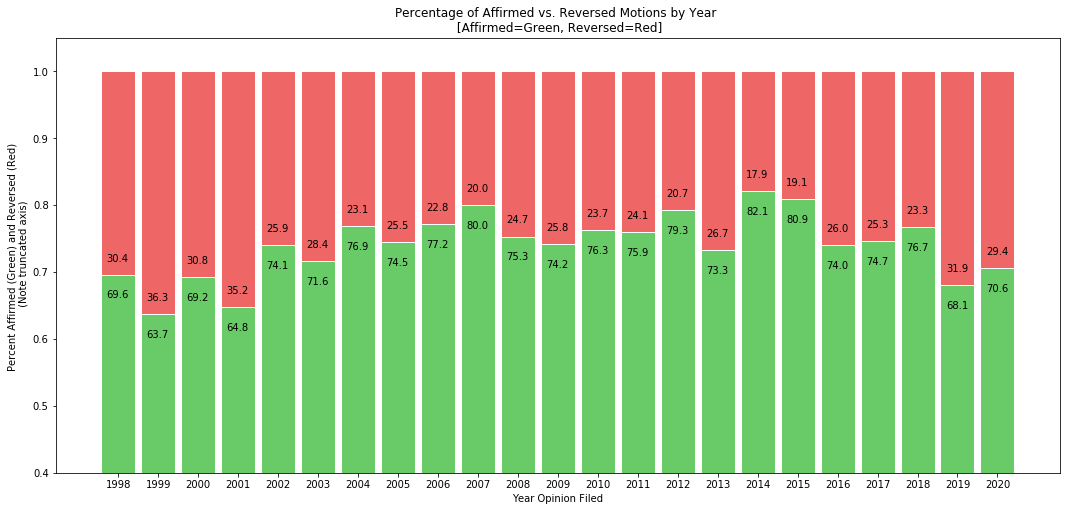

In [67]:
# Visualize On-Time Departures by the Departure Window
r = [x for x in range(1998,2021)]
greenBars = df_affirmed.percent_affirmed
redBars = df_affirmed.percent_reversed
barWidth = 0.85
names = r
# Create green Bars
plt.figure(figsize=(18,8))
plt.bar(r, greenBars, color='#69CB67', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, redBars, bottom=greenBars, color='#EE6666', edgecolor='white', width=barWidth)
plt.xticks(r, names)
plt.ylabel("Percent Affirmed (Green) and Reversed (Red) \n (Note truncated axis)")
plt.xlabel("Year Opinion Filed")
plt.title("Percentage of Affirmed vs. Reversed Motions by Year \n [Affirmed=Green, Reversed=Red]")

ax = plt.gca()
ax.set_ylim(0.4, ax.get_ylim()[1])

for i in range(len(r)):
  plt.annotate(round(df_affirmed.percent_affirmed[i]*100,1), 
               xy=(r[i]-.29,(df_affirmed.percent_affirmed[i] - 0.035)), color='black')
  plt.annotate(round(df_affirmed.percent_reversed[i]*100,1), 
               xy=(r[i]-.29,(df_affirmed.percent_affirmed[i] + 0.02)), color='black')

plt.show()

The cases generally favor affirming trial-court decisions, with only between 17.9% (2014) and 36.3% (1999) of trial-court decisions being reversed over the twenty-two year look-back period. There is no obvious pattern over the corpus' time frame, which is **reassuring** for our model, that time does not appear to play a significant role. 

### B. Corpus by Percentage of Case Type

In [68]:
#Horizontal bar chart
t1 = df.groupby(['Case_Type'])['Result'].sum()
t2 = df.groupby(['Case_Type'])['Result'].count()
df_casetype = pd.concat([t1, t2], axis = 1)
df_casetype.columns = ['Affirmed','Total']
df_casetype['percent_affirmed'] = df_casetype.Affirmed / df_casetype.Total
df_casetype.reset_index(inplace=True)

In [69]:
df_casetype.sort_values(by=['percent_affirmed'], ascending=False, inplace=True)
df_casetype.reset_index(inplace=True, drop=True)

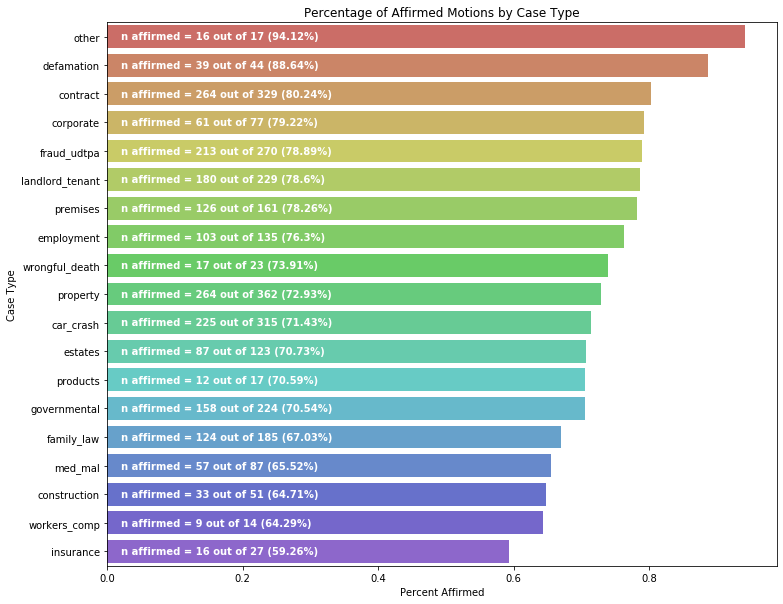

In [70]:
f, ax = plt.subplots(figsize=(12,10))
sns.set_palette("hls", n_colors=25)
sns.barplot(x=df_casetype.percent_affirmed, y=df_casetype.Case_Type)
# sns.set_color_codes("hls", 8)
ax.set(ylabel="Case Type",
       xlabel="Percent Affirmed",
       title="Percentage of Affirmed Motions by Case Type")
for i in range(len(df_casetype)):
    anno = 'n affirmed = ' + str(df_casetype.Affirmed[i]) + ' out of ' + str(df_casetype.Total[i]) + ' (' + str(round(df_casetype.percent_affirmed[i]*100,2)) + '%)'
    plt.annotate(anno, 
               xy=(.02, i+.1), color='white', weight='bold')
plt.show()

While most cases are affirmed regardless of case type, this chart illustrates the relative likelihood of a given case type to be affirmed following a summary judgment motion, as compared to the other case types. The sample sizes of each type shown on the chart also illustrate the sample sizes, which give insight into the reliability of each case type's percentage.

### C. Percent Granted by Case Type and Year 

Scuttled -- Final plot was an incomprehensible mess since there were so many variations between 0-1.0 and so many case types. 

### D. Trial Judge 

In [71]:
z1 = df.groupby(['Trial_Judge'])['Result'].sum()
z2 = df.groupby(['Trial_Judge'])['Result'].count()
df_judge = pd.concat([z1, z2], axis = 1)
df_judge.columns = ['Affirmed','Total']
df_judge['percent_affirmed'] = df_judge.Affirmed / df_judge.Total
df_judge.reset_index(inplace=True)

In [72]:
df_judge.sort_values(by=['Total'], ascending=False, inplace=True)
df_judge.reset_index(inplace=True, drop=True)

In [73]:
df_judge = df_judge[:20]

In [74]:
def judge_name(list_):
    string_ = list_.strip('[]').replace('\'','')
    return string_.title()

In [75]:
df_judge.Trial_Judge = df_judge.Trial_Judge.apply(lambda x: judge_name(x))

In [76]:
df_judge.sort_values(by=['percent_affirmed'], ascending=False, inplace=True)
df_judge.reset_index(inplace=True, drop=True)

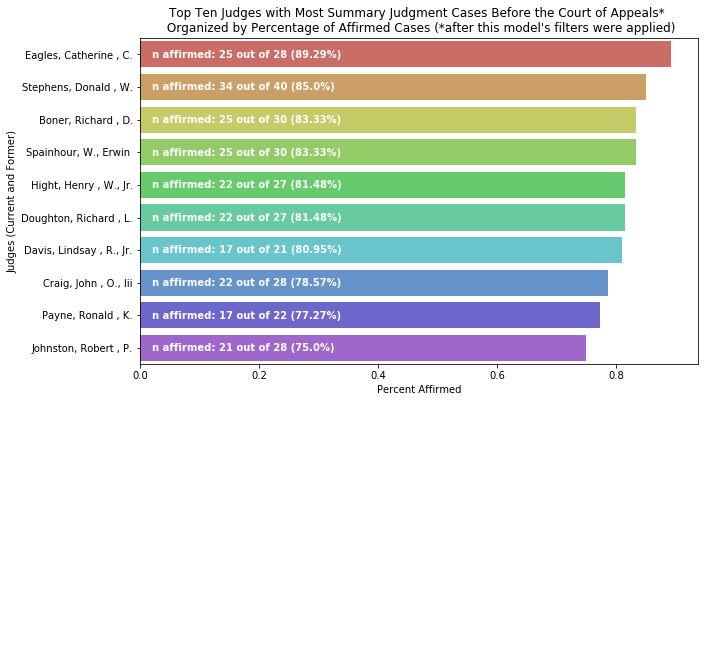

In [77]:
f, ax = plt.subplots(figsize=(10,6))
sns.set_palette("hls", n_colors=12)
sns.barplot(x=df_judge.percent_affirmed[:10], y=df_judge.Trial_Judge[:10])
ax.set(ylabel="Judges (Current and Former)",
       xlabel="Percent Affirmed",
       title="Top Ten Judges with Most Summary Judgment Cases Before the Court of Appeals* \n Organized by Percentage of Affirmed Cases (*after this model's filters were applied)")

for i in range(len(df_casetype)):
    anno = 'n affirmed: ' + str(df_judge.Affirmed[i]) + ' out of ' + str(df_judge.Total[i]) + ' (' + str(round(df_judge.percent_affirmed[i]*100,2)) + '%)'
    plt.annotate(anno, 
               xy=(.02, i+.1), color='white', weight='bold')
plt.show()

## 9. Export Final DataFrame

In [78]:
# Save the new DF to a data file
with open('ProjectData/df_features.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(df, filehandle)   